<a href="https://colab.research.google.com/github/Taketo-Muroya/Adv-ML/blob/master/Assignment_3_for_Adv_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #3: BBC text classification data

### 1) Visualize the categories of your target variable and describe the dataset generally (the data includes news articles from the BBC news.) A simple description is fine.

In [0]:
# load the BCC news data

import pandas as pd
df = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


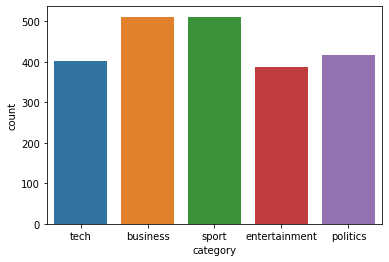

In [2]:
# visualize the target variable, category

import seaborn as sns
ax = sns.countplot(x="category", data=df)

In [3]:
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [74]:
# check the size of text on average

from statistics import mean
text_size = [len(word) for word in df.text]
round(mean(text_size))

2263

The dataset has 2225 observations in total and each observation has a category and text data. The target variable would be 5 categories, tech, business, sport, entertainment, and politics. This dataset is relatively balanced in terms of the target variable, although business and sport have a little more observations than the rest of them.

### 2) Preprocess your data such that each document in the data is represented as a sequence of equal length.

In [86]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

maxlen = 500  # Cut reviews after 500 words
max_words = 10000  # Consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(df.category)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Set up training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=42)


Found 29726 unique tokens.
Shape of data tensor: (2225, 500)
Shape of label tensor: (2225,)


In [89]:
x_train[0].shape

(500,)

In [90]:
y_train[0]

'business'

### 3) Use the data to fit separate models to each of the following architectures:

### A) A model with an embedding layer and dense layers (but w/ no layers meant for sequential data)

In [91]:
from keras.layers import Dense, Embedding, Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()

# Specify the size of your vocabulary (i.e.-10,000 terms)
# Specify the number of features you want to extract via fitting weights to your embedding matrix.
# We also specify the maximum input length to our Embedding layer
model.add(Embedding(10000, 128, input_length=maxlen))

# After the Embedding layer, our activations have shape `(samples, maxlen, 128)`.
# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 128)`
model.add(Flatten())

model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 64000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 320005    
Total params: 1,600,005
Trainable params: 1,600,005
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1334 samples, validate on 334 samples
Epoch 1/10
1334/1334 [==============================] - 1s 889us/step - loss: 1.4332 - acc: 0.4048 - val_loss: 1.1599 - val_acc: 0.6437
Epoch 2/10
1334/1334 [==============================] - 1s 841us/step - loss: 0.4415 - acc: 0.9633 - val_loss: 0.5702 - val_acc: 0.8503
Epoch 3/10
1334/1334 [==============================] - 1s 864us/step - loss: 0.0741 - acc: 0.9985 - val_loss: 0.3218 - val_acc: 0.9341
Epoch 4/10
1334/1334 [==============================] - 1s 848us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.2144 - val_acc: 0.9401
Epoch 5/10
1334/1334 [==============================] - 1s 825us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9521
Epoch 6/10
1334/1334 [==============================] - 1s 842us/step - loss: 2.2539e-04 - acc: 1.0000 - val_loss: 0.1396 - val_acc: 0.9581
Epoch 7/10
1334/1334 [==============================] - 1s 840us/step - loss: 2.9951e-05 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 

In [93]:
# evaluate a model performance
model.evaluate(x_test, pd.get_dummies(y_test))

557/557 [==============================] - 0s 96us/step


[0.23492747518489776, 0.9192100763320923]

### B) A model using an Embedding layer with Conv1d Layers

In [97]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(10000, 128, input_length=maxlen))
model.add(layers.Conv1D(64, 7, activation='relu')) 
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 494, 64)           57408     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 92, 32)            14368     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 165       
Total params: 1,351,941
Trainable params: 1,351,941
Non-trainable params: 0
___________________________________________

In [98]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) # RMSprop(lr=1e-4)
history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1334 samples, validate on 334 samples
Epoch 1/10
1334/1334 [==============================] - 8s 6ms/step - loss: 1.5832 - acc: 0.2504 - val_loss: 1.5442 - val_acc: 0.3114
Epoch 2/10
1334/1334 [==============================] - 7s 6ms/step - loss: 1.3823 - acc: 0.5570 - val_loss: 1.2655 - val_acc: 0.5240
Epoch 3/10
1334/1334 [==============================] - 7s 6ms/step - loss: 0.8094 - acc: 0.8216 - val_loss: 0.5502 - val_acc: 0.9072
Epoch 4/10
1334/1334 [==============================] - 7s 6ms/step - loss: 0.2617 - acc: 0.9715 - val_loss: 0.2335 - val_acc: 0.9461
Epoch 5/10
1334/1334 [==============================] - 7s 6ms/step - loss: 0.0610 - acc: 0.9948 - val_loss: 0.1400 - val_acc: 0.9521
Epoch 6/10
1334/1334 [==============================] - 7s 6ms/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.1381 - val_acc: 0.9401
Epoch 7/10
1334/1334 [==============================] - 7s 6ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1437 - val_acc: 0.9581
Epoch 8/10
1334

In [99]:
# evaluate a model performance
model.evaluate(x_test, pd.get_dummies(y_test))

557/557 [==============================] - 1s 1ms/step


[0.1583551076914667, 0.9569120407104492]

### C) A model using an Embedding layer with one sequential layer (LSTM or GRU)

In [103]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 128, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.summary()


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 500, 64)           49408     
_________________________________________________________________
flatten_13 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 160005    
Total params: 1,489,413
Trainable params: 1,489,413
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1334 samples, validate on 334 samples
Epoch 1/10
1334/1334 [==============================] - 17s 13ms/step - loss: 1.0007 - acc: 0.5892 - val_loss: 0.2679 - val_acc: 0.9162
Epoch 2/10
1334/1334 [==============================] - 17s 12ms/step - loss: 0.1469 - acc: 0.9625 - val_loss: 0.2167 - val_acc: 0.9192
Epoch 3/10
1334/1334 [==============================] - 17s 13ms/step - loss: 0.0203 - acc: 0.9955 - val_loss: 0.3081 - val_acc: 0.9012
Epoch 4/10
1334/1334 [==============================] - 17s 13ms/step - loss: 0.0141 - acc: 0.9940 - val_loss: 0.0586 - val_acc: 0.9760
Epoch 5/10
1334/1334 [==============================] - 17s 13ms/step - loss: 1.3475e-04 - acc: 1.0000 - val_loss: 0.0728 - val_acc: 0.9790
Epoch 6/10
1334/1334 [==============================] - 17s 13ms/step - loss: 9.9088e-06 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9790
Epoch 7/10
1334/1334 [==============================] - 17s 12ms/step - loss: 5.8121e-07 - acc: 1.0000 - val_loss: 0.0755 - val_a

In [105]:
# evaluate a model performance
model.evaluate(x_test, pd.get_dummies(y_test))

557/557 [==============================] - 1s 2ms/step


[0.31052038939239407, 0.9569120407104492]

### D) A model using an Embedding layer with stacked sequential layers (LSTM or GRU)

In [106]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 500, 64)           49408     
_________________________________________________________________
lstm_20 (LSTM)               (None, 500, 32)           12416     
_________________________________________________________________
lstm_21 (LSTM)               (None, 500, 16)           3136      
_________________________________________________________________
flatten_14 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 40005     
Total params: 1,384,965
Trainable params: 1,384,965
Non-trainable params: 0
___________________________________________

In [107]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1334 samples, validate on 334 samples
Epoch 1/10
1334/1334 [==============================] - 37s 27ms/step - loss: 1.1606 - acc: 0.4865 - val_loss: 0.6532 - val_acc: 0.7575
Epoch 2/10
1334/1334 [==============================] - 35s 26ms/step - loss: 0.3364 - acc: 0.8816 - val_loss: 0.1567 - val_acc: 0.9401
Epoch 3/10
1334/1334 [==============================] - 36s 27ms/step - loss: 0.0986 - acc: 0.9663 - val_loss: 0.3235 - val_acc: 0.8892
Epoch 4/10
1334/1334 [==============================] - 36s 27ms/step - loss: 0.0814 - acc: 0.9805 - val_loss: 0.1554 - val_acc: 0.9551
Epoch 5/10
1334/1334 [==============================] - 36s 27ms/step - loss: 9.0636e-04 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9611
Epoch 6/10
1334/1334 [==============================] - 36s 27ms/step - loss: 4.0551e-05 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9611
Epoch 7/10
1334/1334 [==============================] - 36s 27ms/step - loss: 3.0029e-06 - acc: 1.0000 - val_loss: 0.1691 - val_a

In [108]:
# evaluate a model performance
model.evaluate(x_test, pd.get_dummies(y_test))

557/557 [==============================] - 3s 5ms/step


[0.314217863132913, 0.92998206615448]

### E) A model using an Embedding layer with bidirectional sequential layers

In [109]:
model = Sequential()
model.add(layers.Embedding(10000, 128, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 128)          98816     
_________________________________________________________________
flatten_15 (Flatten)         (None, 64000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 320005    
Total params: 1,698,821
Trainable params: 1,698,821
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1334 samples, validate on 334 samples
Epoch 1/10
1334/1334 [==============================] - 33s 25ms/step - loss: 0.9208 - acc: 0.6282 - val_loss: 0.2685 - val_acc: 0.9012
Epoch 2/10
1334/1334 [==============================] - 32s 24ms/step - loss: 0.1145 - acc: 0.9640 - val_loss: 0.2641 - val_acc: 0.9072
Epoch 3/10
1334/1334 [==============================] - 32s 24ms/step - loss: 0.0294 - acc: 0.9918 - val_loss: 0.0999 - val_acc: 0.9701
Epoch 4/10
1334/1334 [==============================] - 32s 24ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.1053 - val_acc: 0.9671
Epoch 5/10
1334/1334 [==============================] - 32s 24ms/step - loss: 0.0125 - acc: 0.9955 - val_loss: 3.2274 - val_acc: 0.6766
Epoch 6/10
1334/1334 [==============================] - 32s 24ms/step - loss: 0.0393 - acc: 0.9963 - val_loss: 0.0854 - val_acc: 0.9731
Epoch 7/10
1334/1334 [==============================] - 32s 24ms/step - loss: 1.1798e-05 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.97

In [112]:
# evaluate a model performance
model.evaluate(x_test, pd.get_dummies(y_test))

557/557 [==============================] - 2s 4ms/step


[0.18806765052277588, 0.9640933275222778]

### F) Now retrain your best model from C, D, and E using dropout (you may need to increase epochs!)

In [120]:
model = Sequential()
model.add(layers.Embedding(10000, 128, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 128)          98816     
_________________________________________________________________
flatten_17 (Flatten)         (None, 64000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 320005    
Total params: 1,698,821
Trainable params: 1,698,821
Non-trainable params: 0
_________________________________________________________________


In [121]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, pd.get_dummies(y_train), epochs=20, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1334 samples, validate on 334 samples
Epoch 1/20
1334/1334 [==============================] - 34s 26ms/step - loss: 0.9262 - acc: 0.6394 - val_loss: 0.2891 - val_acc: 0.8952
Epoch 2/20
1334/1334 [==============================] - 33s 25ms/step - loss: 0.1540 - acc: 0.9483 - val_loss: 0.1456 - val_acc: 0.9611
Epoch 3/20
1334/1334 [==============================] - 33s 25ms/step - loss: 0.0377 - acc: 0.9888 - val_loss: 0.1167 - val_acc: 0.9611
Epoch 4/20
1334/1334 [==============================] - 33s 25ms/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.3603 - val_acc: 0.8922
Epoch 5/20
1334/1334 [==============================] - 33s 25ms/step - loss: 0.0059 - acc: 0.9985 - val_loss: 0.1228 - val_acc: 0.9641
Epoch 6/20
1334/1334 [==============================] - 33s 25ms/step - loss: 0.0131 - acc: 0.9963 - val_loss: 0.0895 - val_acc: 0.9731
Epoch 7/20
1334/1334 [==============================] - 33s 25ms/step - loss: 1.2998e-04 - acc: 1.0000 - val_loss: 0.0894 - val_acc: 0.97

In [122]:
# evaluate a model performance
model.evaluate(x_test, pd.get_dummies(y_test))

557/557 [==============================] - 2s 4ms/step


[0.23345005375674224, 0.9569120407104492]

### 4) Discuss 1) which model(s) performed best and speculate about 2) how you might try to further improve the predictive power of your model (e.g. Glove embeddings? More layers? Combining Conv1D with LSTM layers? More LSTM hidden nodes?)

1. which model(s) performed best
> The best model for me is the one using an embedding layer with bidirectional sequential layers, which output the best accuracy score. The technique of bidirectional layers seems to be powerful in terms of interpreting the text data well. Although the droupout also seems to be a good tool to improve the model, it did not work so much for my model this time.

2. how you might try to further improve the predictive power of your model
> For the further improvement, using the glove embeddings might be helpful because the pre-trained embeddings might enhance the understanding of text sometimes. For the number of layers, I'm not sure that its increase would contribute to the improvement of accuracy because the stacked LSTM layers did not improve my model. In addition, the combination of Conv1D and LSTM might improve the model in a sense that they have different structures and this mix might capture well the features of the text data. The more LSTM nodes might improve the model depending on the number of features in words embeddings. If you set a large number of features in the word embedding, the larger number of nodes might work well sometimes.